In [1]:
import matplotlib.pyplot as plt
from skimage import io, color
import numpy as np
import os
import pandas as pd
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.model_selection import KFold
import random
random.seed(1337)

In [2]:
path = '..'
loadingpath = path + '/Paintings91_enhanced'
writingpath = path + '/Paintings91_Enhanced/Cropped_paintings'

impath = loadingpath + '/Images'
labelpath = loadingpath + '/Labels'

imlist = os.listdir(impath)

labelfile = labelpath + '/imagedata.csv'
dblabels = pd.read_csv(labelfile)
dblabels.head()

,filename,label,labelnum,iswrong,train
0,../Paintings91_enhanced/Images/ALBRECHT_DURER_...,ALBRECHT_DURER,0,False,True
1,../Paintings91_enhanced/Images/ALBRECHT_DURER_...,ALBRECHT_DURER,0,False,True
2,../Paintings91_enhanced/Images/ALBRECHT_DURER_...,ALBRECHT_DURER,0,False,True
3,../Paintings91_enhanced/Images/ALBRECHT_DURER_...,ALBRECHT_DURER,0,False,True
4,../Paintings91_enhanced/Images/ALBRECHT_DURER_...,ALBRECHT_DURER,0,False,True


In [3]:
dblabels.shape

(5359, 5)

<BarContainer object of 100 artists>

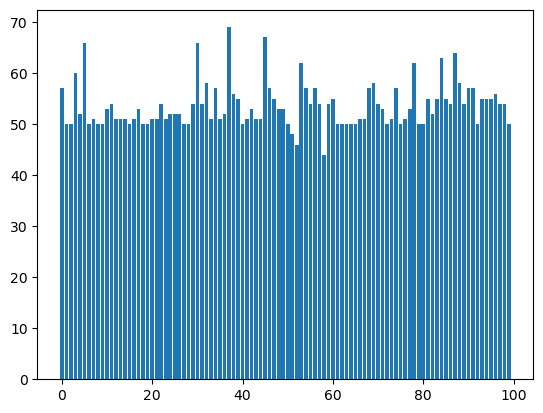

In [4]:
counts = dblabels.labelnum.value_counts()
plt.bar(counts.keys(), counts)

In [5]:
max(counts)

69

In [6]:
#method responsible for setting crop cordinates for image
def rectangles(image, num,minsize = -1):
    rects = []
    rows = image.shape[0]
    cols = image.shape[1]
    if minsize == -1:
        minsize = 0.1 *  min([rows,cols])
    for i in range(num):
        r1 = np.random.randint(0, rows-minsize)
        c1 = np.random.randint(0, cols-minsize)
        r2 = np.random.randint(r1+minsize,rows)
        c2 = np.random.randint(c1+minsize,cols)
        smaller_dim = min((r2-r1, c2-c1)) # Turn it into a square crop
        r2 = r1 + smaller_dim
        c2 = c1 + smaller_dim
        rects.append([r1,c1,r2,c2])
    return np.array(rects)

def grid(image, gridsize=50, stride = 10):
    rects = []
    rows = image.shape[0]
    cols = image.shape[1]
    for i in range(0,rows-gridsize,stride):
        for j in range(0,cols-gridsize,stride):
            r1 = i
            c1 = j
            r2 = i+gridsize
            c2 = j+gridsize
            rects.append([r1,c1,r2,c2])
    return np.array(rects)

def drawbox(image, r1,c1,r2,c2,thickness=3,color=(255,255,0)):
    if len(image.shape)==2:
        image = np.stack((image, image, image), axis = 2)
    newimage = image.copy()
    for plane in range(3):
        newimage[r1:r2, c1:c2, plane] = color[plane]
        newimage[r1+thickness:r2-thickness,c1+thickness:c2-thickness,plane] = image[r1+thickness:r2-thickness,c1+thickness:c2-thickness,plane]
    return newimage
    
    



## loading and cropping images

In [7]:
row1s = []
col1s = []
row2s = []
col2s = []

mainfilenames = []
cropfilenames = []
labels = []
labelnums = []

numcrops = 25

for filenum in range(len(dblabels.filename)):
    # # If it's a wrong file, skip it.
    # if dblabels['iswrong'][filenum] == True:
    #     continue
    # if we have trained enough images for a class, skip the rest
    if dblabels['train'][filenum] == False:
        continue
    
    filename = dblabels['filename'][filenum]
    if filenum == 0 or dblabels['labelnum'][filenum] != dblabels['labelnum'][filenum-1]:
        print(filename,'\t',dblabels['label'][filenum],'\t',dblabels['labelnum'][filenum])

    
    try:
        img = io.imread(filename)
    except:
        print('Error in file: ' + filename)
        continue
        
    if len(np.shape(img)) == 3:
        if img.shape[2] == 4:
            img = img[:,:,:3]
    else:
        img = np.stack([img,img,img],axis = 2)
    
    boxes = rectangles(img, numcrops) #[r1,c1,r2,c2]
    file = filename.split('/')[-1]
    file = file.split('.')[0]

    for b in range(boxes.shape[0]):
        crop = img[boxes[b][0]:boxes[b][2],boxes[b][1]:boxes[b][3],:]
        cropfilename = writingpath + '/' + file + '_' + str(b) + '.jpg'
        row1s.append(boxes[b,0])
        col1s.append(boxes[b,1])
        row2s.append(boxes[b,2])
        col2s.append(boxes[b,3])
        
        mainfilenames.append(filename)
        cropfilenames.append(cropfilename)
        labels.append(dblabels['label'][filenum])
        labelnums.append(dblabels['labelnum'][filenum])
        io.imsave(cropfilename,crop,check_contrast=False)

        
data = {'mainfilename':mainfilenames,'cropfilename':cropfilenames,'row1':row1s,'col1':col1s,'row2':row2s,'col2':col2s,'label':labels,'labelnum':labelnums}
cropdf = pd.DataFrame.from_dict(data)
cropdf.to_csv(labelpath + '/' + 'cropdata.csv')        

../Paintings91_enhanced/Images/ALBRECHT_DURER_1.jpg 	 ALBRECHT_DURER 	 0
../Paintings91_enhanced/Images/AMEDEO_MODIGLIANI_1.jpg 	 AMEDEO_MODIGLIANI 	 1
../Paintings91_enhanced/Images/AMRITA_SHER-GIL_1.jpg 	 AMRITA_SHER-GIL 	 2
../Paintings91_enhanced/Images/ANDREA_MANTEGNA_1.jpg 	 ANDREA_MANTEGNA 	 3
../Paintings91_enhanced/Images/ANDY_WARHOL_1.jpg 	 ANDY_WARHOL 	 4
../Paintings91_enhanced/Images/ARSHILLE_GORKY_1.jpg 	 ARSHILLE_GORKY 	 5
../Paintings91_enhanced/Images/CAMILLE_COROT_1.jpg 	 CAMILLE_COROT 	 6
../Paintings91_enhanced/Images/CARAVAGGIO_1.jpg 	 CARAVAGGIO 	 7
../Paintings91_enhanced/Images/CASPAR_DAVID_FRIEDRICH_1.jpg 	 CASPAR_DAVID_FRIEDRICH 	 8
../Paintings91_enhanced/Images/CLAUDE_LORRAIN_1.jpg 	 CLAUDE_LORRAIN 	 9
../Paintings91_enhanced/Images/CLAUDE_MONET_1.jpg 	 CLAUDE_MONET 	 10
../Paintings91_enhanced/Images/DANTE_GABRIEL_ROSSETTI_1.jpg 	 DANTE_GABRIEL_ROSSETTI 	 11
../Paintings91_enhanced/Images/DAVID_HOCKNEY_1.jpg 	 DAVID_HOCKNEY 	 12
../Paintings91_enhanced/Imag

C:\Users\banerji\Anaconda3\envs\wakanda\lib\site-packages\PIL\TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 33723 had too many entries: 4, expected 1
  warnings.warn(


../Paintings91_enhanced/Images/EDOUARD_MANET_1.jpg 	 EDOUARD_MANET 	 15
../Paintings91_enhanced/Images/EDVARD_MUNCH_1.jpg 	 EDVARD_MUNCH 	 16
../Paintings91_enhanced/Images/EDWARD_HOPPER_1.jpg 	 EDWARD_HOPPER 	 17
../Paintings91_enhanced/Images/EGON_SCHIELE_1.jpg 	 EGON_SCHIELE 	 18
../Paintings91_enhanced/Images/EL_LISSITZKY_1.jpg 	 EL_LISSITZKY 	 19
../Paintings91_enhanced/Images/EUGENE_DELACROIX_1.jpg 	 EUGENE_DELACROIX 	 20
../Paintings91_enhanced/Images/FERNAND_LEGER_1.jpg 	 FERNAND_LEGER 	 21
../Paintings91_enhanced/Images/FRA_ANGELICO_1.jpg 	 FRA_ANGELICO 	 22
../Paintings91_enhanced/Images/FRANCIS_BACON_1.jpg 	 FRANCIS_BACON 	 23
../Paintings91_enhanced/Images/FRANCISCO_DE_GOYA_1.jpg 	 FRANCISCO_DE_GOYA 	 24
../Paintings91_enhanced/Images/FRANCISCO_DE_ZURBARAN_1.jpg 	 FRANCISCO_DE_ZURBARAN 	 25
../Paintings91_enhanced/Images/FRANS_HALS_1.jpg 	 FRANS_HALS 	 26
../Paintings91_enhanced/Images/FRANZ_MARC_1.jpg 	 FRANZ_MARC 	 27


C:\Users\banerji\Anaconda3\envs\wakanda\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


../Paintings91_enhanced/Images/Frederic_Edwin_Church_1.jpg 	 Frederic_Edwin_Church 	 28
../Paintings91_enhanced/Images/FRIDA_KAHLO_1.jpg 	 FRIDA_KAHLO 	 29
../Paintings91_enhanced/Images/GENTILESCHI_ARTEMISIA_1.jpg 	 GENTILESCHI_ARTEMISIA 	 30
../Paintings91_enhanced/Images/GEORGES_BRAQUE_1.jpg 	 GEORGES_BRAQUE 	 31
../Paintings91_enhanced/Images/GEORGES_DE_LA_TOUR_1.jpg 	 GEORGES_DE_LA_TOUR 	 32
../Paintings91_enhanced/Images/GEORGES_SEURAT_1.jpg 	 GEORGES_SEURAT 	 33
../Paintings91_enhanced/Images/GEORGIA_OKEEFE_1.jpg 	 GEORGIA_OKEEFE 	 34
../Paintings91_enhanced/Images/GERHARD_RICHTER_1.jpg 	 GERHARD_RICHTER 	 35
../Paintings91_enhanced/Images/GIORGIO_DE_CHIRICO_1.jpg 	 GIORGIO_DE_CHIRICO 	 36
../Paintings91_enhanced/Images/GIORGIONE_1.jpg 	 GIORGIONE 	 37
../Paintings91_enhanced/Images/GIOTTO_DI_BONDONE_1.jpg 	 GIOTTO_DI_BONDONE 	 38
../Paintings91_enhanced/Images/GUSTAV_KLIMT_1.jpg 	 GUSTAV_KLIMT 	 39
../Paintings91_enhanced/Images/GUSTAVE_COURBET_1.jpg 	 GUSTAVE_COURBET 	 40
../P

C:\Users\banerji\Anaconda3\envs\wakanda\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (98530000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


../Paintings91_enhanced/Images/HANS_MEMLING_1.jpg 	 HANS_MEMLING 	 43
../Paintings91_enhanced/Images/HENRI_MATISSE_1.jpg 	 HENRI_MATISSE 	 44
../Paintings91_enhanced/Images/HIERONYMUS_BOSCH_1.jpg 	 HIERONYMUS_BOSCH 	 45
../Paintings91_enhanced/Images/JACKSON_POLLOCK_1.jpg 	 JACKSON_POLLOCK 	 46
../Paintings91_enhanced/Images/JACQUES-LOUIS_DAVID_1.jpg 	 JACQUES-LOUIS_DAVID 	 47
../Paintings91_enhanced/Images/JAMES_ENSOR_1.jpg 	 JAMES_ENSOR 	 48
../Paintings91_enhanced/Images/JAMES_MCNEILL_WHISTLER_1.jpg 	 JAMES_MCNEILL_WHISTLER 	 49
../Paintings91_enhanced/Images/JAMINI_ROY_1.jpg 	 JAMINI_ROY 	 50
../Paintings91_enhanced/Images/JAN_VAN_EYCK_1.jpg 	 JAN_VAN_EYCK 	 51
../Paintings91_enhanced/Images/JAN_VERMEER_1.jpg 	 JAN_VERMEER 	 52
../Paintings91_enhanced/Images/JASPER_JOHNS_1.jpg 	 JASPER_JOHNS 	 53
../Paintings91_enhanced/Images/JEAN-ANTOINE_WATTEAU_1.jpg 	 JEAN-ANTOINE_WATTEAU 	 54
../Paintings91_enhanced/Images/JEAN-AUGUSTE-DOMINIQUE_INGRES_1.jpg 	 JEAN-AUGUSTE-DOMINIQUE_INGRES 	 5